In [1]:
#  imports
import os
import sys
import time
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from config import cfg

ModuleNotFoundError: No module named 'config'

In [ ]:
data_path = "/Users/rufaelmarew/Documents/tau/finger_pose_estimation/dataset/FPE/S1/p3/fpe_pos3_001_S1_rep0_BT.edf"
leap_path = "/Users/rufaelmarew/Documents/tau/finger_pose_estimation/dataset/FPE/S1/p3/fpe_pos3_001_S1_rep0_BT.csv"

In [14]:
def read_emg(path, start_time=None, end_time=None, fs: int=250):

    raw = mne.io.read_raw_edf(path, preload=True)

    # get header
    header = raw.info

    if start_time is None:
        start_time = header['meas_date']
        # convert to pd.datetime from datetime.datetime
        start_time = pd.to_datetime(start_time).tz_localize(None)
        # remove 2 hours
        start_time = start_time - pd.to_timedelta(2, unit='h')
        print(start_time)
    
    #  get annotations
    annotations = raw.annotations
    annotations.onset = start_time + pd.to_timedelta(annotations.onset, unit='s')
    
    # get annotations as df
    to_append = []
    for ind, (i,j) in enumerate(zip(annotations.onset, annotations.description)):
        if 'start' in j:
            if 'end_' in annotations.description[ind+1]:
                new_j = j.replace('start', '').strip('_')
                #  add 1 sec ofset to onset and append
                offset = pd.to_timedelta(1, unit='s')
                to_append.append([annotations.onset[ind]+offset, annotations.onset[ind+1]+offset, new_j])
        
    ann_df = pd.DataFrame(to_append, columns=['start_time', 'end_time', 'gesture'])
    #  if duration is greater than 10 sec, drop
    ann_df = ann_df[ann_df['end_time'] - ann_df['start_time'] < pd.to_timedelta(10, unit='s')]


    emg_df = raw.to_data_frame()
    emg_df['time'] = pd.to_datetime(emg_df['time'], unit='s', origin=start_time)
    emg_df.set_index('time', inplace=True)

    # start data from first annotation
    start_time = ann_df['start_time'].iloc[0]
    emg_df = emg_df[start_time:]
    
    #  resample emg data to fs Hz
    emg_df = emg_df.resample(f'{int(1000/fs)}ms', origin='start').mean()

    return emg_df, ann_df, header

emg_data, ann, header = read_emg(path = data_path)

Extracting EDF parameters from /Users/rufaelmarew/Documents/tau/finger_pose_estimation/dataset/FPE/S1/p3/fpe_pos3_001_S1_rep0_BT.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 135499  =      0.000 ...   541.996 secs...
2024-01-02 11:17:25


In [15]:
def read_leap(path, fs=125):

    leap_df = pd.read_csv(path, index_col=False)

    # drop null and duplicates
    leap_df.dropna(inplace=True)
    leap_df.drop_duplicates(inplace=True, subset=['time'])

    leap_df['time'] = pd.to_datetime(leap_df['time'])
    leap_df['time'] = leap_df['time'].dt.tz_localize(None)
    leap_df = leap_df.set_index('time')

    # calculate relative position
    for i in leap_df.columns:
        if 'position_x' in i:
            leap_df[i] = leap_df[i] - leap_df['palm_x']
        elif 'position_y' in i:
            leap_df[i] = leap_df[i] - leap_df['palm_y']
        elif 'position_z' in i:
            leap_df[i] = leap_df[i] - leap_df['palm_z']
        else:
            continue
    
    # leap_df = leap_df.resample(f'{int(1000/fs)}ms', origin='start').ffill()

    # valid_columns = build_leap_columns()
    # leap_df = leap_df[valid_columns]

    return leap_df, None, None

leap_data, _, _ = read_leap(leap_path)

In [16]:
start_time = max(min(leap_data.index), min(emg_data.index))
end_time = min(max(leap_data.index), max(emg_data.index))

leap_data = leap_data.loc[start_time:end_time]
emg_data = emg_data.loc[start_time:end_time]

In [17]:
def create_windowed_dataset(df, w, s, fs):
    # Convert window size and stride from seconds to number of rows
    w_rows = int(w * fs)
    s_rows = int(s * fs)
    print(w_rows, s_rows)
    print(df.shape)
    data = []
    times = []
    for i in range(0, len(df) - w_rows, s_rows):
        window = df.iloc[i:i+w_rows]
        data.append(window.values)
        times.append(window.index[-1])

    data = np.array(data)
    times = np.array(times)

    # Reshape data to (N-w)/(S)*W*C
    data = data.reshape((-1, w_rows , df.shape[1]))

    return data, times

data, times = create_windowed_dataset(emg_data, 1, 0.1, fs=250)
data.shape, times.shape

250 25
(125809, 16)


((5023, 250, 16), (5023,))

In [18]:
# get gesture if time is between start and end time
def get_gesture(time, ann_df):
    gesture_df = ann_df[(ann_df['start_time'] <= time) & (ann_df['end_time'] >= time)]
    if not gesture_df.empty:
        return gesture_df['gesture'].iloc[0]
    return 'rest'
t = get_gesture(times[0], ann)
print(t)

threefingers


In [20]:
# Get the indices of the leap data that are closest to the times array
def find_closest(leap_data, times, annotations):
    index = []
    gestures = []   
    for i in times:
        #  find the time indeex closest to i
        index.append(leap_data.index.asof(i))
        gestures.append(get_gesture(i,annotations))
        #  find the gesture closest to i
    leap_closest = leap_data.loc[index]
    
    return leap_closest.to_numpy(), gestures

index, gestures = find_closest(leap_data, times, ann)

In [22]:
data.shape, index.shape, len(gestures)

((5023, 250, 16), (5023, 147), 5023)

In [26]:
# value couts for each gesture
def get_gesture_counts(gestures):
    return pd.Series(gestures).value_counts()
get_gesture_counts(gestures)

rest            2527
twofingers       253
abduction        252
kaf              252
tet              251
het              251
fist             250
bet              250
gimel            248
nun              248
threefingers     241
Name: count, dtype: int64

In [11]:
import glob
import os
def read_dirs(data_path):
    if not os.path.isdir(data_path):
        raise ValueError(f'{data_path} is not a directory')

    # Traverse through all the directories and read the data
    all_files = [f for f in glob.glob(os.path.join(data_path, '**/*'), recursive=True) if os.path.splitext(f)[1] in ['.edf', '.csv']]

    # Separate .edf and .csv files
    edf_files = sorted([file for file in all_files if file.endswith('.edf')])
    csv_files = sorted([file for file in all_files if file.endswith('.csv')])

    return edf_files, csv_files

edf_files, csv_files = read_dirs('../dataset/FPE/')    

In [13]:
csv_files

['../dataset/FPE/S1/p1/fpe_pos1_001_S1_rep0_BT.csv',
 '../dataset/FPE/S1/p2/fpe_pos2_001_S1_rep0_BT.csv',
 '../dataset/FPE/S1/p3/fpe_pos3_001_S1_rep0_BT.csv',
 '../dataset/FPE/S1/p4/fpe_pos4_001_S1_rep0_BT.csv']

#### Final Dataset Class test

In [2]:
import sys
sys.path.append('../')
from config import cfg
from data import make_dataset, make_exp_dataset
print(cfg)
cfg.DEBUG = False
cfg.DATA.PATH = '../dataset/FPE/S1'
cfg.DATA.EMG.SAMPLING_RATE = 250
cfg.DATA.SEGMENT_LENGTH = 200
cfg.DATA.STRIDE = 5
cfg.DATA.EXP_SETUP = 'exp1'


dataset = make_exp_dataset(cfg)

DATA:
  EMG:
    BUFF_LEN: 0
    FEATURE_EXTRACTOR: RMS
    HIGH_FREQ: 400
    LOW_FREQ: 10
    NORMALIZATION: max
    NOTCH_FREQ: 50
    NUM_CHANNELS: 16
    Q: 30
    SAMPLING_RATE: 250
    WINDOW_SIZE: 100
    WINDOW_STRIDE: 50
  EXP_SETUP: exp0
  FILTER_DATA: True
  ICA: False
  LABEL_COLUMNS: ['Thumb_Metacarpal_position_x', 'Thumb_Metacarpal_position_y', 'Thumb_Metacarpal_position_z', 'Thumb_Proximal_position_x', 'Thumb_Proximal_position_y', 'Thumb_Proximal_position_z', 'Thumb_Intermediate_position_x', 'Thumb_Intermediate_position_y', 'Thumb_Intermediate_position_z', 'Thumb_Distal_position_x', 'Thumb_Distal_position_y', 'Thumb_Distal_position_z', 'Index_Metacarpal_position_x', 'Index_Metacarpal_position_y', 'Index_Metacarpal_position_z', 'Index_Proximal_position_x', 'Index_Proximal_position_y', 'Index_Proximal_position_z', 'Index_Intermediate_position_x', 'Index_Intermediate_position_y', 'Index_Intermediate_position_z', 'Index_Distal_position_x', 'Index_Distal_position_y', 'Index_

AttributeError: 'Subset' object has no attribute 'label_columns'

In [8]:
dataset['train'].dataset.data.shape, dataset['val'].dataset.data.shape, dataset['test'].data.shape

(torch.Size([25136, 200, 16]),
 torch.Size([25136, 200, 16]),
 torch.Size([67803, 200, 16]))

In [14]:
from config import cfg
import os
print(os.sep)
exp_setups = {
    'exp0': None,

    'exp1': {
        'train': [f"S1{os.sep}p1"],
        'test': [f'S1{os.sep}p2']
    },

    'exp2': {
        'train': [f'S1{os.sep}p1', f'S1{os.sep}p2', f'S1{os.sep}p3'],
        'test': [f'S1{os.sep}p4'] 
    },
}

def get_dirs_for_exp(cfg):

    data_path = "./datasets/FPE"
    # if cfg.DATA.EXP_SETUP not in exp_setups.keys():
    #     raise ValueError(f'Invalid experiment setup {cfg.DATA.EXP_SETUP}')
    
    train_dirs = []
    test_dirs = []

    for dir in exp_setups['exp2']['train']:
        train_dirs.append(os.path.join(data_path, dir))

    for dir in exp_setups['exp2']['test']:
        test_dirs.append(os.path.join(data_path, dir))

    return train_dirs, test_dirs
get_dirs_for_exp(cfg)

/


(['./datasets/FPE/S1/p1', './datasets/FPE/S1/p2', './datasets/FPE/S1/p3'],
 ['./datasets/FPE/S1/p4'])

<Axes: >

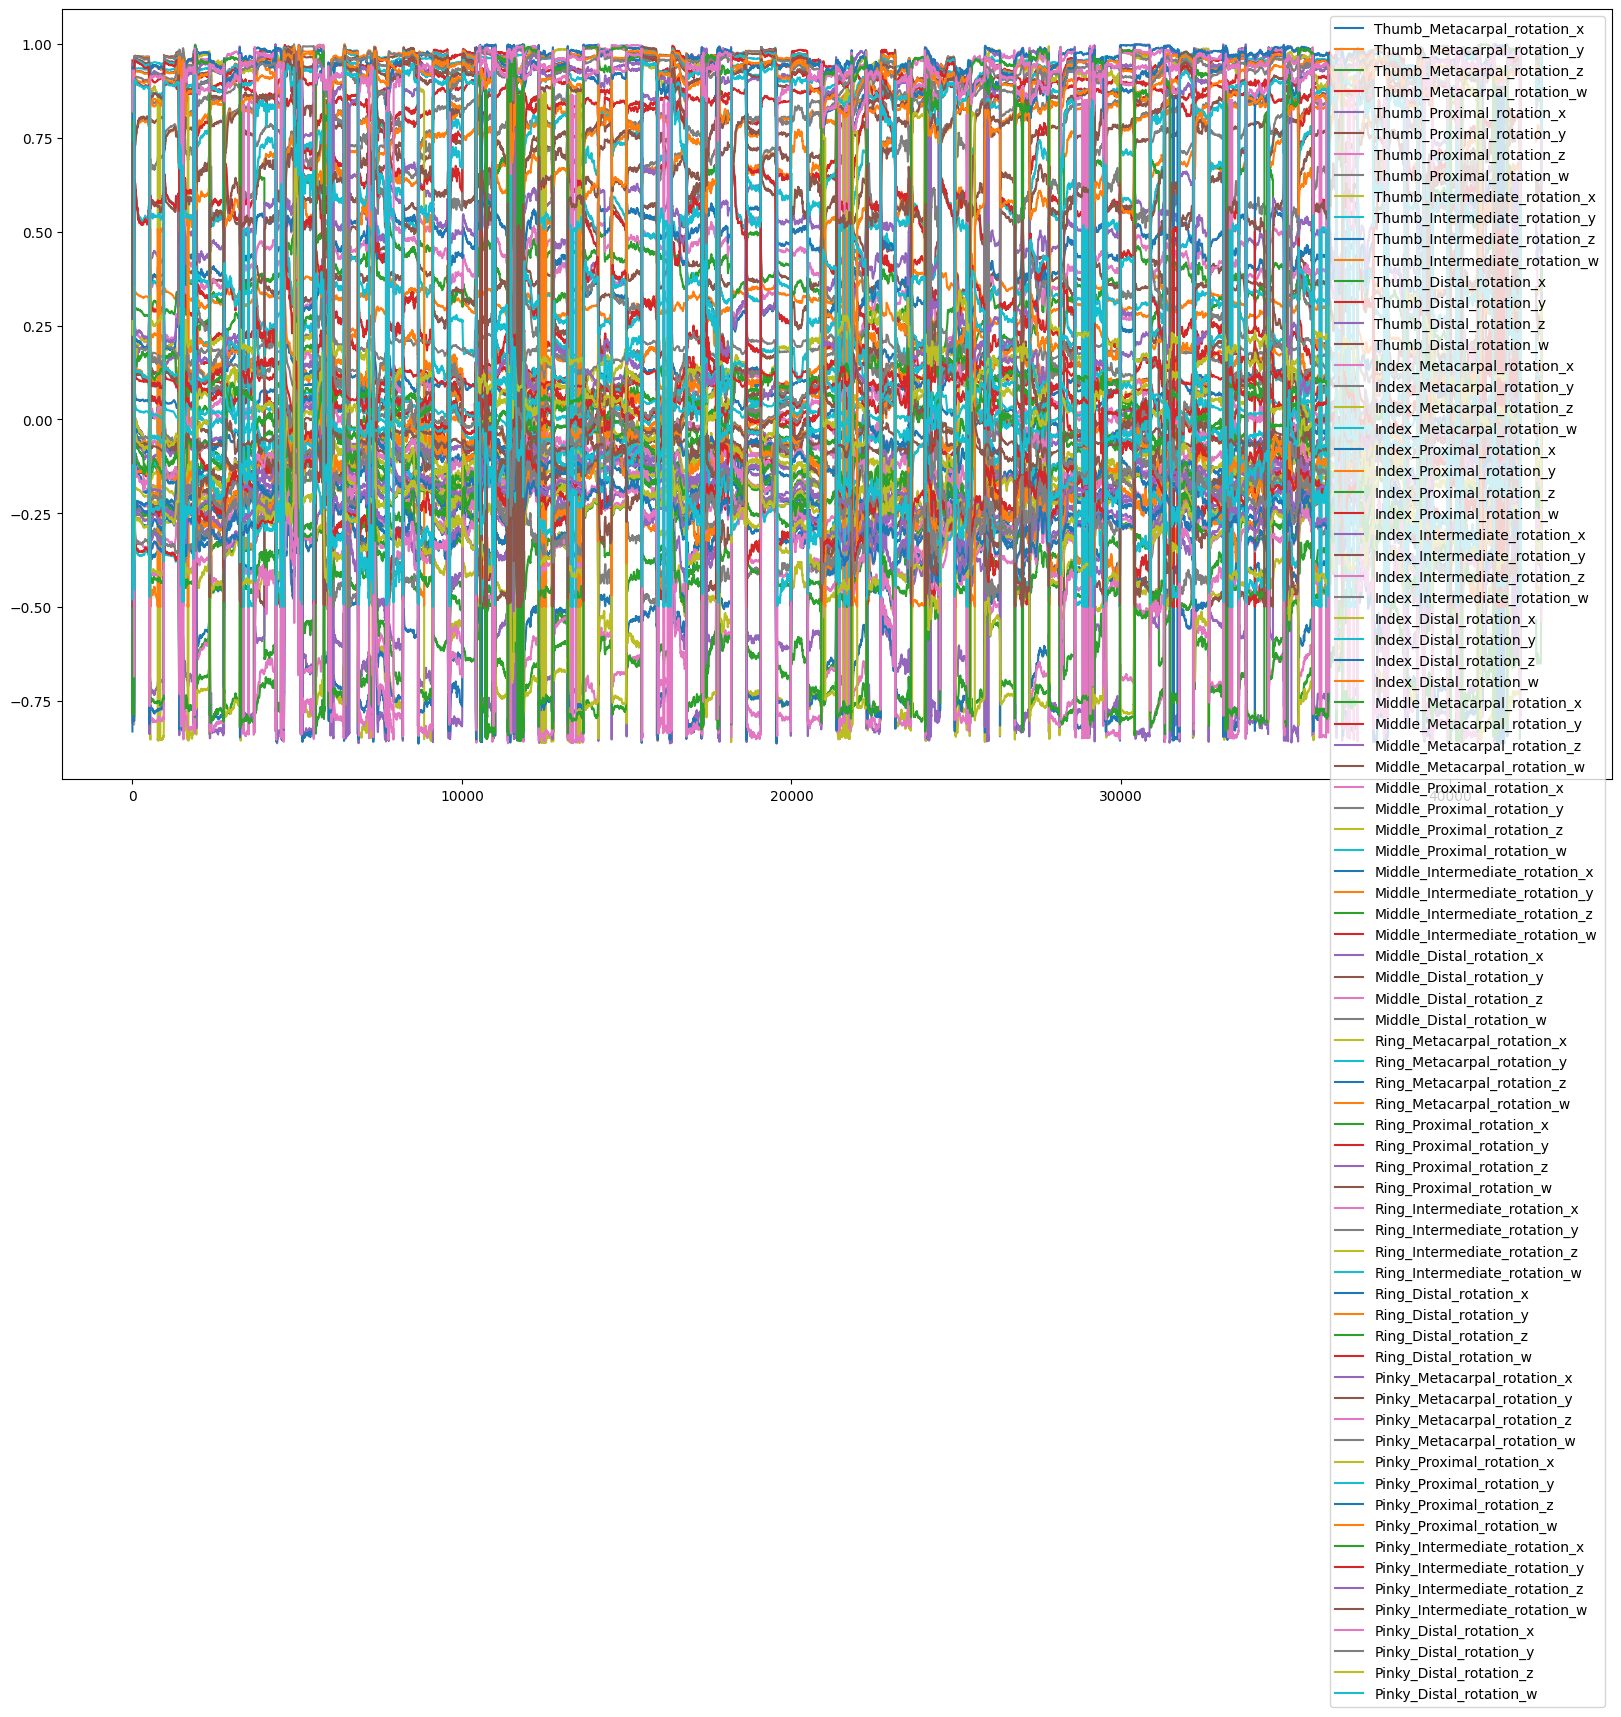

In [6]:
leap_data = pd.read_csv('../dataset/FPE/S1/p1/fpe_pos1_001_S1_rep0_BT.csv')
#  get rotation columns
rotation_columns = [i for i in leap_data.columns if 'rotation' in i]
leap_data[rotation_columns].plot(figsize=(20,10))

In [38]:
import numpy as np
import pandas as pd

def compute_flexion_angles(bones_df):
    """
    Compute flexion angles from quaternion components in a DataFrame.

    Parameters:
    - bones_df (pd.DataFrame): DataFrame containing quaternion components for each bone,
      following the specified column naming convention.

    Returns:
    - pd.DataFrame: DataFrame containing flexion angles in degrees for each bone.
    """

    # Initialize an empty DataFrame to store flexion angles
    flexion_df = pd.DataFrame()

    # Define the original Y-axis vector (upward direction)
    original_y_axis = np.array([0, 1, 0])

    # Iterate over fingers (Thumb, Index, Middle, Ring, Pinky)
    for finger in ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']:
        # Iterate over bone types (Metacarpal, Proximal, Intermediate, Distal)
        for bone_type in ['Metacarpal', 'Proximal', 'Intermediate', 'Distal']:
            # Extract quaternion columns for the current bone
            quaternion_columns = [f"{finger}_{bone_type}_rotation_{coord}" for coord in ['z', 'x', 'y', 'w']]
            quaternion_values = bones_df[quaternion_columns]

            # Reshape the quaternion values to a 2D array and convert to a rotation matrix
            quaternion_matrix = np.array(quaternion_values).reshape(4, -1)
            rotation_matrix = np.array([
                [1 - 2 * quaternion_matrix[2, :] ** 2 - 2 * quaternion_matrix[3, :] ** 2,
                 2 * quaternion_matrix[1, :] * quaternion_matrix[2, :] - 2 * quaternion_matrix[3, :] * quaternion_matrix[0, :],
                 2 * quaternion_matrix[1, :] * quaternion_matrix[3, :] + 2 * quaternion_matrix[2, :] * quaternion_matrix[0, :]],
                [2 * quaternion_matrix[1, :] * quaternion_matrix[2, :] + 2 * quaternion_matrix[3, :] * quaternion_matrix[0, :],
                 1 - 2 * quaternion_matrix[1, :] ** 2 - 2 * quaternion_matrix[3, :] ** 2,
                 2 * quaternion_matrix[2, :] * quaternion_matrix[3, :] - 2 * quaternion_matrix[1, :] * quaternion_matrix[0, :]],
                [2 * quaternion_matrix[1, :] * quaternion_matrix[3, :] - 2 * quaternion_matrix[2, :] * quaternion_matrix[0, :],
                 2 * quaternion_matrix[2, :] * quaternion_matrix[3, :] + 2 * quaternion_matrix[1, :] * quaternion_matrix[0, :],
                 1 - 2 * quaternion_matrix[1, :] ** 2 - 2 * quaternion_matrix[2, :] ** 2]
            ])

            # Extract the rotated Y-axis vector
            rotated_y_axis = rotation_matrix[:, 1]

            # Compute the dot product, clip to ensure it's within [-1, 1], and then compute the flexion angle
            dot_product = np.clip(np.dot(original_y_axis, rotated_y_axis), -1, 1)
            flexion_angle = np.arccos(dot_product)

            # Convert the angle to degrees and append to the flexion DataFrame
            flexion_df[f"{finger}_{bone_type}_Flexion_"] = np.degrees(flexion_angle)

    return flexion_df

# Example usage:
# Assuming 'df' is your DataFrame with quaternion components
leap_data.dropna(inplace=True)
flexion_angles = compute_flexion_angles(leap_data)
# df_with_flexion = pd.concat([df, flexion_angles], axis=1)


In [39]:
flexion_angles.isna().sum()

Thumb_Metacarpal_Flexion_       0
Thumb_Proximal_Flexion_         0
Thumb_Intermediate_Flexion_     0
Thumb_Distal_Flexion_           0
Index_Metacarpal_Flexion_       0
Index_Proximal_Flexion_         0
Index_Intermediate_Flexion_     0
Index_Distal_Flexion_           0
Middle_Metacarpal_Flexion_      0
Middle_Proximal_Flexion_        0
Middle_Intermediate_Flexion_    0
Middle_Distal_Flexion_          0
Ring_Metacarpal_Flexion_        0
Ring_Proximal_Flexion_          0
Ring_Intermediate_Flexion_      0
Ring_Distal_Flexion_            0
Pinky_Metacarpal_Flexion_       0
Pinky_Proximal_Flexion_         0
Pinky_Intermediate_Flexion_     0
Pinky_Distal_Flexion_           0
dtype: int64

array([[<Axes: title={'center': 'Thumb_Metacarpal_Flexion_'}>,
        <Axes: title={'center': 'Thumb_Proximal_Flexion_'}>,
        <Axes: title={'center': 'Thumb_Intermediate_Flexion_'}>,
        <Axes: title={'center': 'Thumb_Distal_Flexion_'}>],
       [<Axes: title={'center': 'Index_Metacarpal_Flexion_'}>,
        <Axes: title={'center': 'Index_Proximal_Flexion_'}>,
        <Axes: title={'center': 'Index_Intermediate_Flexion_'}>,
        <Axes: title={'center': 'Index_Distal_Flexion_'}>],
       [<Axes: title={'center': 'Middle_Metacarpal_Flexion_'}>,
        <Axes: title={'center': 'Middle_Proximal_Flexion_'}>,
        <Axes: title={'center': 'Middle_Intermediate_Flexion_'}>,
        <Axes: title={'center': 'Middle_Distal_Flexion_'}>],
       [<Axes: title={'center': 'Ring_Metacarpal_Flexion_'}>,
        <Axes: title={'center': 'Ring_Proximal_Flexion_'}>,
        <Axes: title={'center': 'Ring_Intermediate_Flexion_'}>,
        <Axes: title={'center': 'Ring_Distal_Flexion_'}>],
    

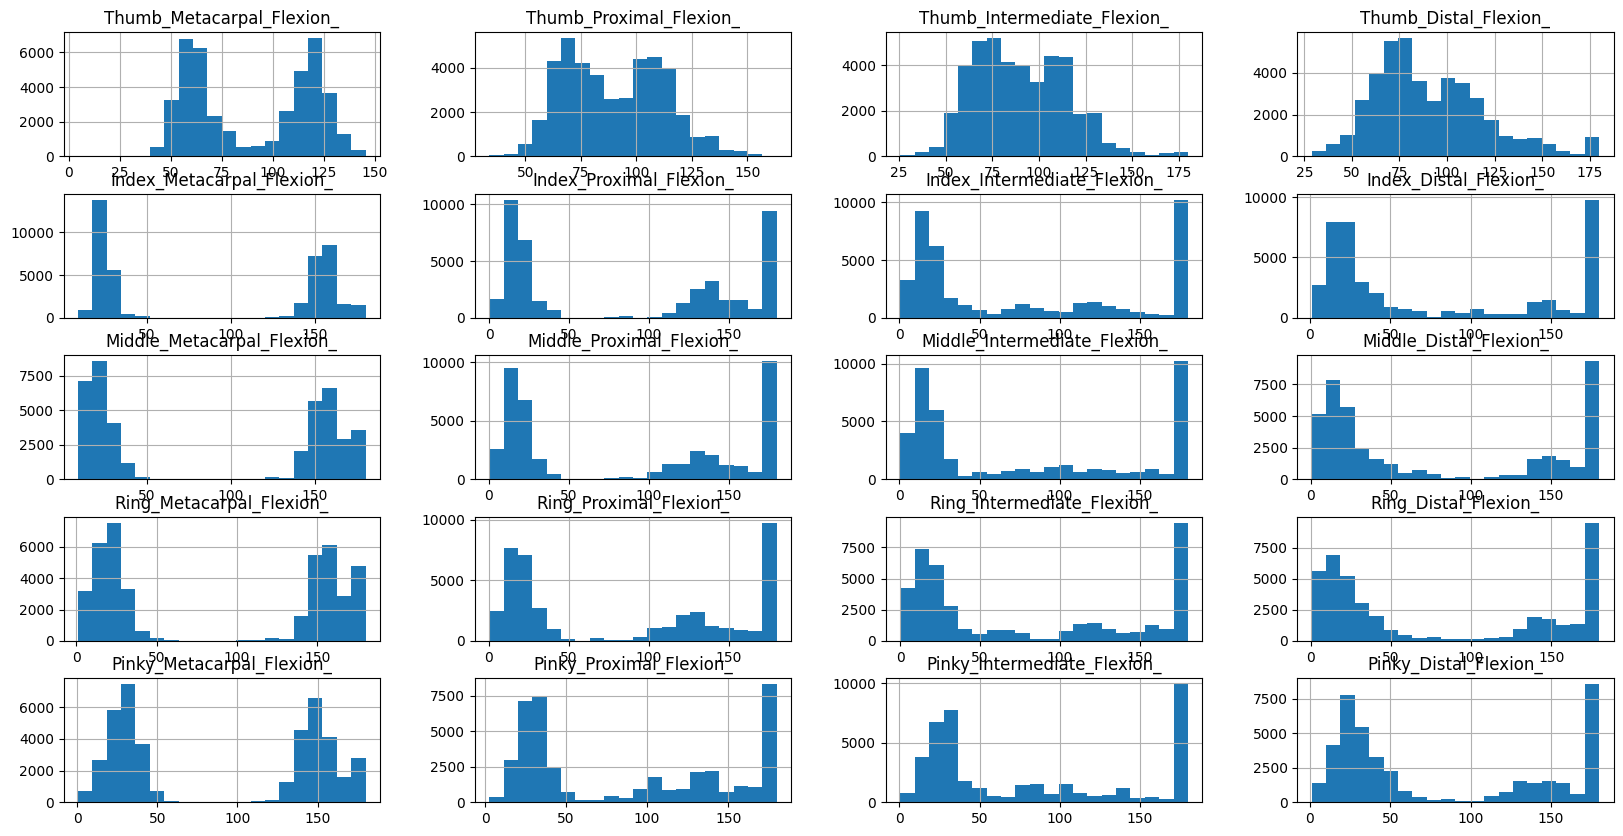

In [44]:
flexion_angles.hist(bins=20 ,figsize=(20,10))